# Pandas and plots

All data stored in `/data` folder

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib.patches import ConnectionPatch

## 'Real data'

### Functions for reading .gff and .bed

For gff:

In [11]:
def read_gff(filepath):
    colnames=['chromosome', 'source', 'type', 
              'start', 'end', 'score', 'strand',
              'phase', 'attributes']
    df = pd.read_csv(filepath, sep='\t', names=colnames, skiprows=1)
    return df
#read_gff("data/rrna_annotation.gff")

Same function, but now _attributes_  column contains only rRNA type.

In [12]:
def read_gff_no_attr(filepath):
    colnames=['chromosome', 'source', 'type',
              'start', 'end', 'score', 'strand',
              'phase', 'RNA type']
    df = pd.read_csv(filepath, sep='\t', names=colnames, skiprows=1)
    df['RNA type'] = df['RNA type'].apply(lambda str: str[5:str.find("_")])
    return df
#read_gff("data/rrna_annotation.gff")

Function for bed:

In [13]:
def read_bed6(filepath):
    colnames=['chromosome', 'start', 'end',
              'name', 'score', 'strand']
    df = pd.read_csv(filepath, sep='\t', names=colnames)
    return df
#read_bed6('data/alignment.bed')

### Plotting

Table for gff

In [18]:
table = read_gff_no_attr("data/rrna_annotation.gff").groupby(['chromosome','RNA type'])['RNA type'].count()
table = table.to_frame(name='count').reset_index()
table


,chromosome,RNA type,count
0,Reference_1,16S,2
1,Reference_1,23S,2
2,Reference_1,5S,2
3,Reference_10,16S,5
4,Reference_10,23S,5
...,...,...,...
71,Reference_8,16S,2
72,Reference_8,23S,2
73,Reference_9,16S,6
74,Reference_9,23S,6


Plot

<AxesSubplot:xlabel='chromosome', ylabel='count'>

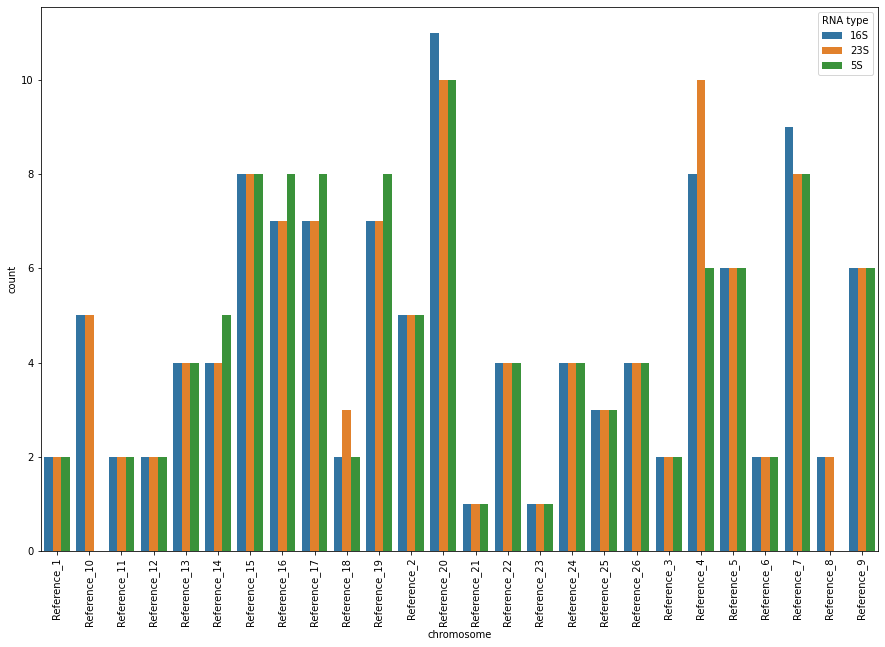

In [19]:
plt.subplots(figsize=(15, 10))
plt.xticks(rotation=90) 
sns.barplot(data=table, x="chromosome", y="count", hue='RNA type')


### Intersecting

In [7]:
ref = read_gff("data/rrna_annotation.gff")
map = read_bed6('data/alignment.bed')

merged = ref.merge(map, on='chromosome')
filtered = merged[(merged['start_x']>=merged['start_y']) & (merged['end_x']<=merged['end_y'])]

filtered

,chromosome,source,type,start_x,end_x,score_x,strand_x,phase,attributes,start_y,end_y,name,score_y,strand_y
129,Reference_11,barrnap:0.9,rRNA,924358,925855,0.000000e+00,+,.,Name=16S_rRNA;product=16S ribosomal RNA,923529,930070,NODE_1081_length_6540_cov_836.773323,0,-
156,Reference_11,barrnap:0.9,rRNA,926697,929642,0.000000e+00,+,.,Name=23S_rRNA;product=23S ribosomal RNA,923529,930070,NODE_1081_length_6540_cov_836.773323,0,-
183,Reference_11,barrnap:0.9,rRNA,929827,929936,1.400000e-12,+,.,Name=5S_rRNA;product=5S ribosomal RNA,923529,930070,NODE_1081_length_6540_cov_836.773323,0,-
215,Reference_11,barrnap:0.9,rRNA,2074460,2075957,0.000000e+00,+,.,Name=16S_rRNA;product=16S ribosomal RNA,2073631,2080172,NODE_1081_length_6540_cov_836.773323,0,-
242,Reference_11,barrnap:0.9,rRNA,2076799,2079744,0.000000e+00,+,.,Name=23S_rRNA;product=23S ribosomal RNA,2073631,2080172,NODE_1081_length_6540_cov_836.773323,0,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121855,Reference_14,barrnap:0.9,rRNA,2433040,2433152,2.000000e-12,-,.,Name=5S_rRNA;product=5S ribosomal RNA,2433027,2433434,NODE_6108_length_407_cov_1153.232955,0,+
122182,Reference_14,barrnap:0.9,rRNA,3766952,3767064,2.000000e-12,-,.,Name=5S_rRNA;product=5S ribosomal RNA,3766939,3767346,NODE_6108_length_407_cov_1153.232955,0,+
122583,Reference_25,barrnap:0.9,rRNA,1329370,1329473,2.900000e-10,-,.,Name=5S_rRNA;product=5S ribosomal RNA,1329345,1329810,NODE_5333_length_465_cov_547.609756,0,-
125060,Reference_25,barrnap:0.9,rRNA,1822913,1823016,2.900000e-10,+,.,Name=5S_rRNA;product=5S ribosomal RNA,1822575,1823040,NODE_5333_length_465_cov_547.609756,0,+


## VOLCANO

In [20]:
data=pd.read_csv("data/diffexpr_data.tsv.gz", sep="\t")

# Diabolically lazy way to set gruops for legend
data['legend'] = np.where(data['log_pval']>=1.301,
                       np.where(data['logFC']>0, 'Significantly upregulated','Significantly downregulated'), 
                       np.where(data['logFC']>0, 'Non-significantly upregulated','Non-significantly downregulated'))

# Getting top 2 upregulated and top 2 downregulated genes
top2lowest=data[data['log_pval']>=1.3].sort_values(by='logFC')[:2][['Sample', 'logFC', 'log_pval']]
top2highest=data[data['log_pval']>=1.3].sort_values(by='logFC', ascending=False)[:2][['Sample', 'logFC', 'log_pval']]

top1l=top2lowest.iloc[0]
top2l=top2lowest.iloc[1]
top1h=top2highest.iloc[0]
top2h=top2highest.iloc[1]



It just works... somehow

Text(-10.196480736032145, 12.171498363731793, 'MUC7')

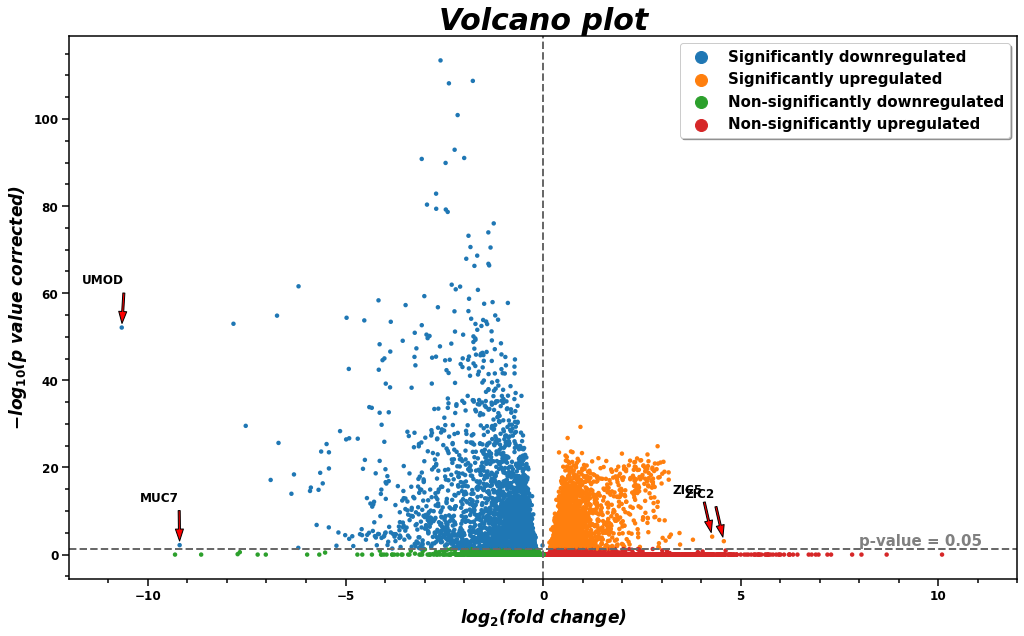

In [13]:
plt.rc("figure", figsize=(17, 10))
plt.rc("font", size=12)
plt.rc("font", style='normal')
#plt.rc("font", weight='bold')
plt.rc("xtick.minor", visible=True)
plt.rc("ytick.minor", visible=True)
plt.rc("xtick.minor", size=4)
plt.rc("ytick.minor", size=4)
plt.rc("xtick.major", size=7)
plt.rc("ytick.major", size=7)
plt.rc("xtick.minor", width=1.5)
plt.rc("ytick.minor", width=1.5)
plt.rc("xtick.major", width=1.5)
plt.rc("ytick.major", width=1.5)
plt.rc("axes", lw=1.5)
sns.scatterplot(data=data, x='logFC', y='log_pval',
               hue='legend', hue_order=['Significantly downregulated', 'Significantly upregulated', 
                                        'Non-significantly downregulated', 'Non-significantly upregulated'],
                linewidth=0, s=20)
plt.legend(shadow=True, markerscale=2, fontsize=15)
plt.axhline(y=1.301, linestyle='--', color='dimgray', lw=2)
plt.axvline(0, linestyle='--', color='dimgray', lw=2)
plt.text(8,2,'p-value = 0.05', color='gray', fontsize=15)
plt.xlabel('$log_{2}$(fold change)', fontsize=17, fontstyle='italic', fontweight='bold')
plt.ylabel('$-log_{10}$(p value corrected)', fontsize=17, fontstyle='italic', fontweight='bold')
xlim=int(max(abs(min(data['logFC'])),max(data['logFC'])))+2
plt.xlim(-xlim, xlim)
plt.title('Volcano plot', fontsize=30, fontstyle='italic', fontweight='bold')
plt.locator_params(axis='x', nbins=5)
plt.annotate(top1h['Sample'],(top1h['logFC'], top1h['log_pval']),
             arrowprops=dict(facecolor='red',width=2, headwidth=8, shrink=0.1),
             xytext = (top1h['logFC']-1, top1h['log_pval']+10),
             fontstyle='normal', fontweight='bold')
plt.annotate(top2h['Sample'],(top2h['logFC'], top2h['log_pval']),
             arrowprops=dict(facecolor='red',width=2, headwidth=8, shrink=0.1),
             xytext = (top2h['logFC']-1, top2h['log_pval']+10),
             fontstyle='normal', fontweight='bold')
plt.annotate(top1l['Sample'],(top1l['logFC'], top1l['log_pval']),
             arrowprops=dict(facecolor='red',width=2, headwidth=8, shrink=0.1),
             xytext = (top1l['logFC']-1, top1l['log_pval']+10),
             fontstyle='normal', fontweight='bold')
plt.annotate(top2l['Sample'],(top2l['logFC'], top2l['log_pval']),
             arrowprops=dict(facecolor='red',width=2, headwidth=8, shrink=0.1),
             xytext = (top2l['logFC']-1, top2l['log_pval']+10),
             fontstyle='normal', fontweight='bold')

# Pie chart
Here my vitality dropped dramatically.

Basically there are two parts - one for bar plot and one for labels, both taken from matplotlib documentation and changed to slightly remind example picture. 

I have no idea how to fight overlapping labels.

https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_and_donut_labels.html

https://matplotlib.org/3.1.0/gallery/pie_and_polar_charts/bar_of_pie.html #older version of article for some reasons fits better

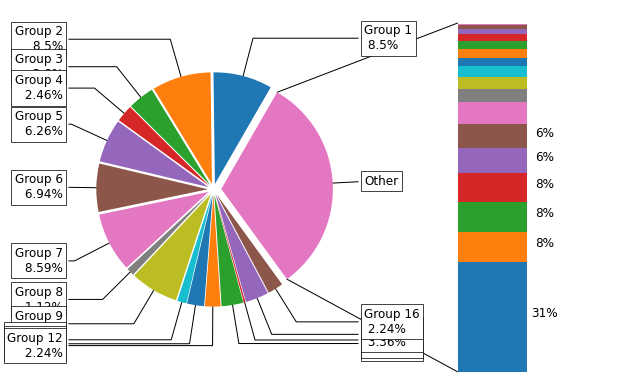

In [88]:
plt.rc("font", weight='normal')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 15), subplot_kw=dict(aspect="equal"))
fig.subplots_adjust(wspace=0)

parts = [8.5, 8.5, 3.8, 2.46, 6.26, 6.94, 8.59, 1.12, 6.94, 1.34, 2.46, 2.24, 3.13, 0.22, 3.36, 2.24, 31.54]
groups = ['Group '+str(i+1)+'\n '+str(parts[i])+'%' for i in range(len(parts)-1)]
groups.append('Other')

angle = 60
expl=[0.05 for i in range(len(parts))]
expl[-1]=0.07
wedges, texts = ax1.pie(parts, startangle = angle ,explode=expl)


bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0.1, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1 
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang)) 
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax1.annotate(groups[i], xy=(x, y), xytext = (1.35*np.sign(x), 1.4*y),
                horizontalalignment=horizontalalignment, **kw)


xpos = 0
bottom = 0
ratios = sorted([i/100 for i in parts], reverse=True)
width = .2


for j in range(len(ratios)):
    height = ratios[j]
    ax2.bar(xpos, height, width, bottom=bottom, linewidth=2)
    ypos = bottom + ax2.patches[j].get_height() / 2
    bottom += height
    if j<=5:
        ax2.text(xpos+0.15, ypos, "%d%%" % (ax2.patches[j].get_height() * 100),
                 ha='center')
    
ax2.axis('off')
ax2.set_xlim(-2*width, 2*width)


# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[-1].theta1, wedges[-1].theta2
center, r = wedges[-1].center, wedges[-1].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData,zorder=0)
con.set_color([0, 0, 0])
con.set_linewidth(1)
ax1.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData,zorder=0)
con.set_color([0, 0, 0])
ax1.add_artist(con)
con.set_linewidth(1)

